In [1]:
import os
import pandas as pd
from typing import List, Dict, Tuple

# Tensorflow
import tensorflow as tf
import tensorflow_recommenders as tfrs

from src.model.tower import Tower
from src.model.embedding import Embedding
from src.model.retrieval import Retrieval
from src.model.ranking import PointwiseRanking
from src.model.recommender import RecommenderModel
from src.model.utils.utilities import (
    train_test_split,
    plot_history
)

RANDOM_STATE = 42
tf.random.set_seed(RANDOM_STATE)
os.environ['TF_USE_LEGACY_KERAS'] = '1'

2024-09-07 17:59:35.867688: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 17:59:35.908178: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-09-07 17:59:35.908215: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-09-07 17:59:35.909597: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-09-07 17:59:35.916934: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2024-09-07 17:59:35.918669: I tensorflow/core/platform/cpu_feature_guard.cc:1

## Load Datasets

In [2]:
# Dataset size (options: 100k, 1m)
DATASET_SIZE: str = '100k'

# Load each dataset
users_df    = pd.read_parquet(f'data/{DATASET_SIZE}-users.parquet')
movies_df   = pd.read_parquet(f'data/{DATASET_SIZE}-movies.parquet')
ratings_df  = pd.read_parquet(f'data/{DATASET_SIZE}-ratings.parquet')

# Remove columns
movies_df.drop(columns=['movie_genres'], inplace=True)

# Handle missing values
movies_df.fillna(value=-1, inplace=True)

# Merge DataFrames
ratings_df = ratings_df.merge(users_df, on = 'user_id')
ratings_df = ratings_df.merge(movies_df, on = 'movie_id')

ratings_df.head()

In [4]:
# Convert the DataFrame to TensorFlow Dataset
ratings_dataset = tf.data.Dataset.from_tensor_slices(dict(ratings_df.astype(str)))
movies_dataset  = tf.data.Dataset.from_tensor_slices(dict(movies_df.astype(str)))
users_dataset   = tf.data.Dataset.from_tensor_slices(dict(users_df.astype(str)))

ratings_dataset = ratings_dataset.map(lambda x: {
    'user_id':                  x['user_id'],
    'movie_id':                 x['movie_id'],
    'timestamp':                int(x['timestamp']),
    'user_rating':              float(x['user_rating']),
    'user_gender':              int(x['user_gender']),
    'user_zip_code':            x['user_zip_code'],
    'user_bucketized_age':      float(x['user_bucketized_age']),
    'user_occupation_label':    int(x['user_occupation_label']),
    'movie_title':              x['movie_title'],
    'movie_release_year':       x['movie_release_year'],
})

movies_dataset = movies_dataset.map(lambda x: {
    'movie_id':                 x['movie_id'],
    'movie_title':              x['movie_title'],
    'movie_release_year':       x['movie_release_year'],
})

users_dataset = users_dataset.map(lambda x: {
    'user_id':                  x['user_id'],
    'user_gender':              int(x['user_gender']),
    'user_zip_code':            x['user_zip_code'],
    'user_bucketized_age':      float(x['user_bucketized_age']),
    'user_occupation_label':    int(x['user_occupation_label']),
})

ratings_dataset.take(1).as_numpy_iterator().next()

2024-09-07 17:59:39.069706: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:01:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-09-07 17:59:39.070192: W tensorflow/core/common_runtime/gpu/gpu_device.cc:2256] Cannot dlopen some GPU libraries. Please make sure the missing libraries mentioned above are installed properly if you would like to use GPU. Follow the guide at https://www.tensorflow.org/install/gpu for how to download and setup the required libraries for your platform.
Skipping registering GPU devices...


{'user_id': b'138',
 'movie_id': b'357',
 'timestamp': 879024327,
 'user_rating': 4.0,
 'user_gender': 1,
 'user_zip_code': b'53211',
 'user_bucketized_age': 45.0,
 'user_occupation_label': 4,
 'movie_title': b"One Flew Over the Cuckoo's Nest",
 'movie_release_year': b'1975'}

In [5]:
TRAIN_RATIO: float = 0.8

# Split into train and validation sets
ratings_trainset, ratings_validset = train_test_split(
    dataset = ratings_dataset,
    train_size = TRAIN_RATIO,
    random_state = RANDOM_STATE,
    buffer_size = 10_000
)

print(f"Training data:", ratings_trainset.__len__().numpy())
print(f"Validation data:", ratings_validset.__len__().numpy())

Training data:	 80000
Validation data: 20000


## Embedding Models

In [6]:
# User Embedding
user_embedding_model = Embedding(
    dataset             = users_dataset.batch(1_000),
    str_features        = ['user_id', 'user_zip_code'],
    int_features        = ['user_gender', 'user_bucketized_age', 'user_occupation_label'],
    text_features       = [],
    timestamp_features  = [],
    embedding_dim       = 32,
)

# Movie Embedding
movie_embedding_model = Embedding(
    dataset             = movies_dataset.batch(1_000),
    str_features        = ['movie_release_year'],
    int_features        = [],
    text_features       = ['movie_title'],
    timestamp_features  = [],
    embedding_dim       = 32,
)

## Towers Models

In [7]:
# Query Tower
query_tower = Tower(
    embedding_model             = user_embedding_model,
    cross_layer_projection_dim  = user_embedding_model.embeddings_output_dim / 2,
    dense_layers                = [32]
)

# Candidate Tower
candidate_tower = Tower(
    embedding_model             = movie_embedding_model,
    cross_layer_projection_dim  = movie_embedding_model.embeddings_output_dim / 2,
    dense_layers                = [32]
)

## Define the Ranking Model

In [8]:
ranking_task = tfrs.tasks.Ranking(
    loss = tf.keras.losses.MeanSquaredError(),      # MSE
    metrics = [
        tf.keras.metrics.RootMeanSquaredError(),    # RMSE
    ],
)

# We will use a ranking model to help train the 
# retrieval system. We will use the pointwise approach
# that assesses the relevance of individual items 
# or documents independently.
ranking_model = PointwiseRanking(
    query_tower     = query_tower,
    candidate_tower = candidate_tower,
    task            = ranking_task
)

## Define the Retrieval Model

In [9]:
# Top K metric
factorized_top_k_metrics = tfrs.metrics.FactorizedTopK(
    candidates = movies_dataset.batch(128).map(candidate_tower)
)

# Retrieval task
retrieval_task = tfrs.tasks.Retrieval(
    metrics = [
        factorized_top_k_metrics
    ]
)

retrieval_model = Retrieval(
    query_tower     = query_tower,
    candidate_tower = candidate_tower,
    task            = retrieval_task
)

## Recommender

In [10]:
RANKING_WEIGHT: float   = 0.8
RETRIEVAL_WEIGHT: float = 0.2
RUN_EAGERLY: bool       = False     # Better debugging, slower training
LEARNING_RATE: float    = 0.1

model = RecommenderModel(
    query_tower      = query_tower,
    candidate_tower  = candidate_tower,
    ranking_model    = ranking_model,
    retrieval_model  = retrieval_model,
    retrieval_weight = RANKING_WEIGHT,
    ranking_weight   = RETRIEVAL_WEIGHT,
)

optimizer = tf.keras.optimizers.Adagrad(learning_rate=LEARNING_RATE)
model.compile(optimizer = optimizer, run_eagerly=RUN_EAGERLY)

In [11]:
EPOCHS: int          = 10
VALIDATION_FREQ: int = 1

cached_ratings_trainset = ratings_trainset.shuffle(100_000).batch(1024).cache()
cached_ratings_validset = ratings_validset.batch(1024).cache()

early_stopping_callback = tf.keras.callbacks.EarlyStopping(
    monitor = 'total_loss',
    patience = 10,
)

history = model.fit(
    cached_ratings_trainset,
    validation_data = cached_ratings_validset,
    validation_freq = VALIDATION_FREQ,
    epochs          = EPOCHS,
    callbacks = [
        early_stopping_callback
    ]
)

Epoch 1/10


79/79 [==============================] - 14s 104ms/step - root_mean_squared_error: 0.0000e+00 - factorized_top_k/top_1_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_5_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_10_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_50_categorical_accuracy: 0.0000e+00 - factorized_top_k/top_100_categorical_accuracy: 0.0000e+00 - loss: 5402.0367 - regularization_loss: 0.0000e+00 - total_loss: 5402.0367 - val_root_mean_squared_error: 1.0919 - val_factorized_top_k/top_1_categorical_accuracy: 0.0014 - val_factorized_top_k/top_5_categorical_accuracy: 0.0097 - val_factorized_top_k/top_10_categorical_accuracy: 0.0200 - val_factorized_top_k/top_50_categorical_accuracy: 0.0966 - val_factorized_top_k/top_100_categorical_accuracy: 0.1849 - val_loss: 2582.4409 - val_regularization_loss: 0.0000e+00 - val_total_loss: 2582.4409
Epoch 2/10
79/79 [==============================] - 4s 48ms/step - root_mean_squared_error: 0.0000e+00 - factorized_

In [12]:
model.evaluate(cached_ratings_validset, return_dict=True, verbose=False)

{'root_mean_squared_error': 1.006468653678894,
 'factorized_top_k/top_1_categorical_accuracy': 0.00039999998989515007,
 'factorized_top_k/top_5_categorical_accuracy': 0.004650000017136335,
 'factorized_top_k/top_10_categorical_accuracy': 0.012550000101327896,
 'factorized_top_k/top_50_categorical_accuracy': 0.0997999981045723,
 'factorized_top_k/top_100_categorical_accuracy': 0.21050000190734863,
 'loss': 2602.058837890625,
 'regularization_loss': 0,
 'total_loss': 2602.058837890625}

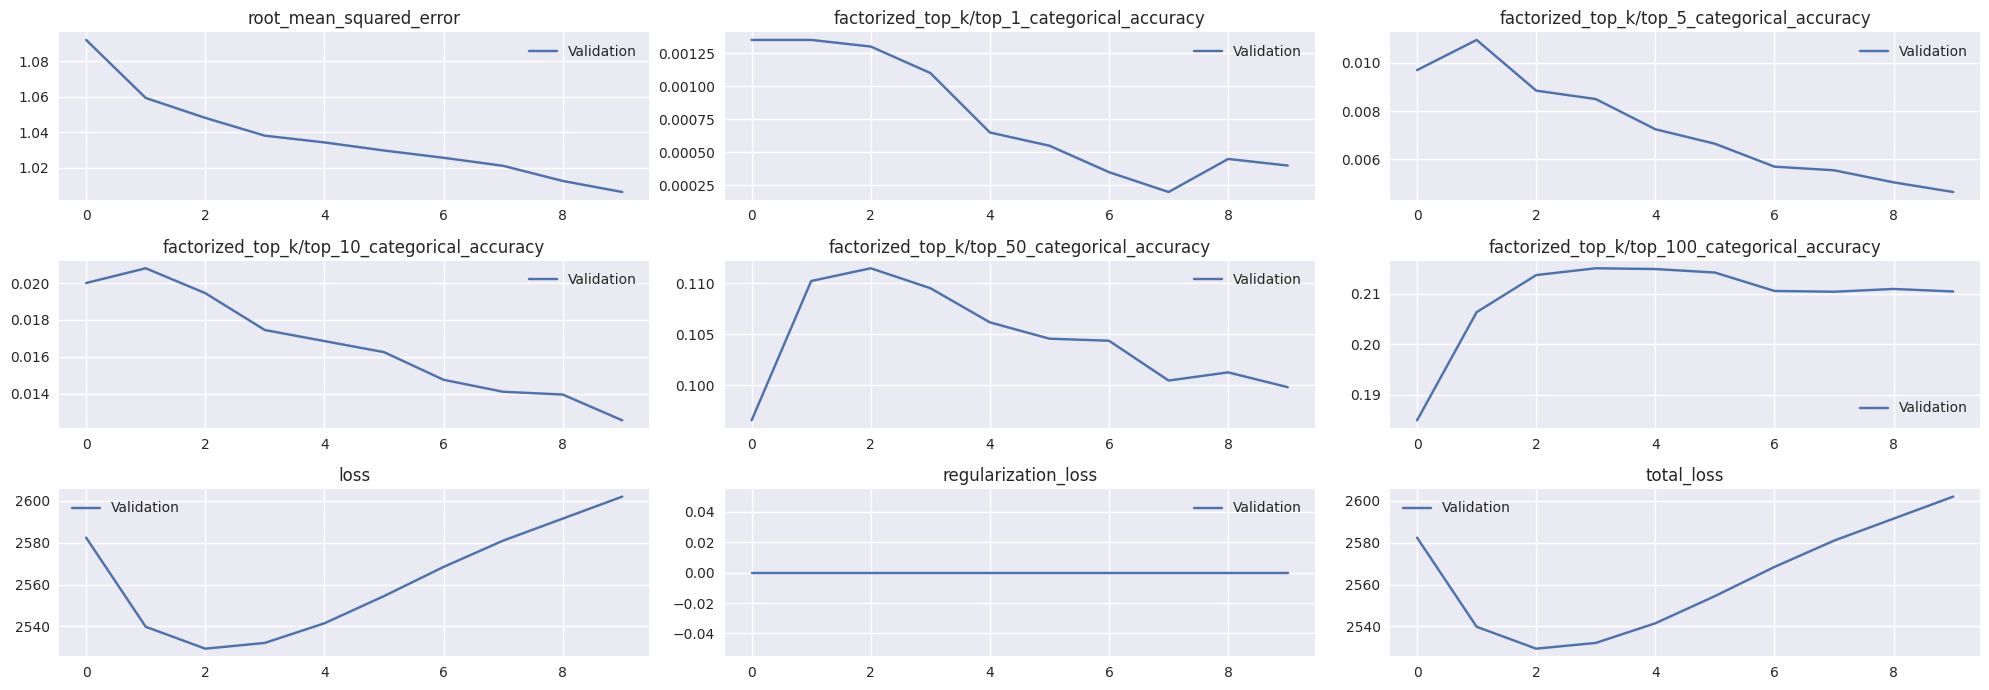

In [13]:
plot_history(history = history, plot_training=False)

In [14]:
TOP_K: int = 10

scann_layer = tfrs.layers.factorized_top_k.ScaNN(
    model.query_tower,
    k = TOP_K,
)

scann_layer.index_from_dataset(
    candidates = tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

2024-09-07 18:00:28.603901: I scann/partitioning/partitioner_factory_base.cc:59] Size of sampled dataset for training partition: 1682
2024-09-07 18:00:28.605283: W scann/utils/gmm_utils.cc:921] Could not normalize centroid due to zero norm or empty or zero-weight partition.
2024-09-07 18:00:28.607647: I ./scann/partitioning/kmeans_tree_partitioner_utils.h:88] PartitionerFactory ran in 3.690736ms.


In [15]:
TOP_K: int = 10

brute_layer = tfrs.layers.factorized_top_k.BruteForce(
    model.query_tower,
    k = TOP_K,
)

brute_layer.index_from_dataset(
    candidates = tf.data.Dataset.zip(
      (
          movies_dataset.map(lambda movie: movie['movie_id']).batch(100),
          movies_dataset.batch(100).map(model.candidate_tower)
      )
  )
)

In [16]:
user = users_dataset.take(1).as_numpy_iterator().next()
user_tensor = {k: tf.convert_to_tensor([v]) for k, v in user.items()}

top_movies = scann_layer(user_tensor, 10)
_, movie_ids = top_movies

for movie_id in movie_ids[0]:
    
    movie = movies_df.loc[movies_df['movie_id'] == movie_id]

    movie_tensor = {k: tf.convert_to_tensor([v]) for k, v in movie.items()}

    pred = model({**movie_tensor, **user_tensor})

    print(f"Movie {movie_id}: {pred[0][0]}")

Movie b'487': 4.318037509918213
Movie b'497': 4.202207088470459
Movie b'430': 4.2972259521484375
Movie b'10': 4.210267543792725
Movie b'165': 4.4708452224731445
Movie b'190': 4.371914386749268
Movie b'923': 4.542384624481201
Movie b'14': 4.232019424438477
Movie b'13': 4.0196757316589355
Movie b'507': 4.397740364074707


In [17]:

user = users_dataset.take(1).as_numpy_iterator().next()
user_tensor = {k: tf.convert_to_tensor([v]) for k, v in user.items()}

top_movies = brute_layer(user_tensor, k=10)
_, movie_ids = top_movies

for movie_id in movie_ids[0]:
    
    movie = movies_df.loc[movies_df['movie_id'] == movie_id]

    movie_tensor = {k: tf.convert_to_tensor([v]) for k, v in movie.items()}

    pred = model({**movie_tensor, **user_tensor})

    print(f"Movie {movie_id}: {pred[0][0]}")

Movie b'513': 4.400745868682861
Movie b'1124': 3.9470112323760986
Movie b'487': 4.318037509918213
Movie b'19': 4.413946628570557
Movie b'497': 4.202207088470459
Movie b'1331': 3.8967652320861816
Movie b'430': 4.2972259521484375
Movie b'1154': 4.062992572784424
Movie b'10': 4.210267543792725
Movie b'190': 4.371914386749268


## Export the Model

In [18]:
class TopK(tf.Module):

    def __init__(self, model: tfrs.layers.factorized_top_k.TopK):
        self.model = model


    @tf.function(
        input_signature = [
            {
                'user_id':               tf.TensorSpec(shape=(1,), dtype=tf.string,  name='user_id'),
                'user_gender':           tf.TensorSpec(shape=(1,), dtype=tf.int32,   name='user_gender'),
                'user_zip_code':         tf.TensorSpec(shape=(1,), dtype=tf.string,  name='user_zip_code'),
                'user_bucketized_age':   tf.TensorSpec(shape=(1,), dtype=tf.float32, name='user_bucketized_age'),
                'user_occupation_label': tf.TensorSpec(shape=(1,), dtype=tf.int32,   name='user_occupation_label'),
            },
            tf.TensorSpec(shape=None, dtype=tf.int32),
        ]
    )
    def call(self, query: Dict[str, tf.Tensor], k: int) -> Tuple[tf.Tensor, tf.Tensor]:
        """
            Call the model

            Parameters:
                - query (Dict[str, tf.Tensor]): Dictionary of input Tensors.
                - k (int): Number of predictions to return.

            Returns:
                (Tuple[tf.Tensor, tf.Tensor]): Tuple of identifiers and affinity scores.
        """
        affinities, identifiers = self.model(query, k)
        return identifiers[0], affinities[0]


class Ranking(tf.Module):

    def __init__(self, model: PointwiseRanking):
        self.model = model


    @tf.function(
        input_signature = [
            {
                'user_id':               tf.TensorSpec(shape=(1,), dtype=tf.string,  name='user_id'),
                'user_gender':           tf.TensorSpec(shape=(1,), dtype=tf.int32,   name='user_gender'),
                'user_zip_code':         tf.TensorSpec(shape=(1,), dtype=tf.string,  name='user_zip_code'),
                'user_bucketized_age':   tf.TensorSpec(shape=(1,), dtype=tf.float32, name='user_bucketized_age'),
                'user_occupation_label': tf.TensorSpec(shape=(1,), dtype=tf.int32,   name='user_occupation_label'),
            },
            {
                'movie_id':              tf.TensorSpec(shape=(1,), dtype=tf.string,  name='movie_id'),
                'movie_title':           tf.TensorSpec(shape=(1,), dtype=tf.string,  name='movie_title'),
                'movie_release_year':    tf.TensorSpec(shape=(1,), dtype=tf.string,   name='movie_release_year'),
            }
        ]
    )
    def call(self, query: Dict[str, tf.Tensor], candidate: Dict[str, tf.Tensor]) -> List[tf.Tensor]:
        """"
            Call the model

            Parameters:
                - query (Dict[str, tf.Tensor]): Dictionary of input Tensors.
                - candidate (Dict[str, tf.Tensor]): Dictionary of input Tensors.

            Returns:
                (Tuple[tf.Tensor, tf.Tensor]): Tuple of identifiers and affinity scores.
        """
        score = self.model({**query, **candidate})
        return score

In [19]:
PATH = './checkpoints'

_scann_layer = TopK(scann_layer)
_brute_layer = TopK(brute_layer)
ranking = Ranking(ranking_model)

tf.saved_model.save(
    obj = _scann_layer,
    export_dir = os.path.join(PATH, 'retrieval/scann'),
    signatures = { 'call': _scann_layer.call },
    options = tf.saved_model.SaveOptions(namespace_whitelist=["Scann"])
)

# Export Brute Force
tf.saved_model.save(
    obj = _brute_layer,
    export_dir = os.path.join(PATH, 'retrieval/brute'),
    signatures = { 'call': _brute_layer.call },
)

# Export Brute Force
tf.saved_model.save(
    obj = ranking,
    export_dir = os.path.join(PATH, 'ranking/pointwise'),
    signatures = { 'call': ranking.call },
)

INFO:tensorflow:Assets written to: ./checkpoints/retrieval/scann/assets


INFO:tensorflow:Assets written to: ./checkpoints/retrieval/scann/assets


INFO:tensorflow:Assets written to: ./checkpoints/retrieval/brute/assets


INFO:tensorflow:Assets written to: ./checkpoints/retrieval/brute/assets


INFO:tensorflow:Assets written to: ./checkpoints/ranking/pointwise/assets


INFO:tensorflow:Assets written to: ./checkpoints/ranking/pointwise/assets


In [20]:
# Load it back; can also be done in TensorFlow Serving.
loaded = tf.saved_model.load("checkpoints/scann")

# Pass a user id in, get top predicted movie titles back.
_ = loaded.signatures['call'](**user_tensor, k=2)

identifiers = list(_['output_0'].numpy())
affnities   = list(_['output_1'].numpy())

dict(zip(identifiers, affnities))

OSError: SavedModel file does not exist at: checkpoints/scann/{saved_model.pbtxt|saved_model.pb}

In [126]:
ranking = tf.saved_model.load("checkpoints/ranking")

query = {
    'user_id': '138',
    'user_gender': 1,
    'user_zip_code': '53211',
    'user_bucketized_age': 45.0,
    'user_occupation_label': 4,
}
candidate = {
    "movie_id": '5',
    "movie_title": 'Copycat',
    "movie_release_year": '1995'
}

query_tensors = {k: tf.convert_to_tensor([v]) for k, v in query.items()}
candidate_tensors = {k: tf.convert_to_tensor([v]) for k, v in candidate.items()}

ranking.signatures['call'](**query_tensors, **candidate_tensors)

{'output_0': <tf.Tensor: shape=(1, 1), dtype=float32, numpy=array([[3.385887]], dtype=float32)>}